In [5]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [8]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
SENSOR_SIZE = (128, 128, 2)
batch_size = 64
NB_EVENTS = 100
filter_time = 10000

Dataset_path = '../data'
Workers = 8
Targetnum = 11

Test_every_iteration = None
Name_suffix = '_step2_pos_neg_diff'
Savemodel_path = './savemodels_DVS/'
Record_path = './recorddata_DVS/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)


class EventChunkDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, chunk_size, transform=None):
        self.dataset = dataset
        self.chunk_size = chunk_size
        self.transform = transform
        self.chunks = []

        for idx in range(len(dataset)):
            events, label = dataset[idx]
            num_events = events.shape[0]
            for start in range(0, num_events, chunk_size):
                end = min(start + chunk_size, num_events)
                self.chunks.append((idx, start, end, label))

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, index):
        idx, start, end, label = self.chunks[index]
        events, _ = self.dataset[idx]
        chunk = events[start:end]
        if self.transform:
            chunk = self.transform(chunk)
        return chunk, label


_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [10]:
# Set paths
output_dir = "./processed_dvsgesture"
train_data_path = os.path.join(output_dir, "train_data"+Name_suffix+".pkl")
test_data_path = os.path.join(output_dir, "test_data"+Name_suffix+".pkl")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if processed data already exists
if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    # Load processed data
    with open(train_data_path, "rb") as f:
        train_images, train_labels = pickle.load(f)
    with open(test_data_path, "rb") as f:
        test_images, test_labels = pickle.load(f)
    print("Loaded preprocessed data from files")
else:
    
    transform = transforms.Denoise(filter_time=filter_time)
    frame_transform = transforms.ToFrame(sensor_size=SENSOR_SIZE)

    dataset_train_base = tonic.datasets.DVSGesture(save_to=Dataset_path, train=True, transform=transform)
    dataset_test_base = tonic.datasets.DVSGesture(save_to=Dataset_path, train=False, transform=transform)

    dataset_train = EventChunkDataset(dataset_train_base, chunk_size=NB_EVENTS, transform=frame_transform)
    dataset_test = EventChunkDataset(dataset_test_base, chunk_size=NB_EVENTS, transform=frame_transform)

    # Function to convert sequences to images
    def convert_to_single_image(frame_sequence):
        time_steps, channels, height, width = frame_sequence.shape
        pos_sum = np.sum(frame_sequence[:, 0, :, :], axis=0)
        neg_sum = np.sum(frame_sequence[:, 1, :, :], axis=0)
        
        result = np.zeros((3, height, width))
        result[0] = pos_sum / max(pos_sum.max(), 1e-6)
        result[1] = neg_sum / max(neg_sum.max(), 1e-6)
        diff = pos_sum - neg_sum
        result[2] = (diff / max(np.abs(diff).max(), 1e-6) + 1) / 2
        return result
    
    # Process training data
    train_images = []
    train_labels = []
    for i, (frames, label) in enumerate(dataset_train):
        if i % 100 == 0:
            print(f"Processing training sample {i}/{len(dataset_train)}")
        img = convert_to_single_image(frames, method='combined')
        train_images.append(torch.FloatTensor(img))
        train_labels.append(label)
    
    # Process test data
    test_images = []
    test_labels = []
    for i, (frames, label) in enumerate(dataset_test):
        if i % 100 == 0:
            print(f"Processing test sample {i}/{len(dataset_test)}")
        img = convert_to_single_image(frames, method='combined')
        test_images.append(torch.FloatTensor(img))
        test_labels.append(label)
    
    # Save processed data
    with open(train_data_path, "wb") as f:
        pickle.dump((train_images, train_labels), f)
    with open(test_data_path, "wb") as f:
        pickle.dump((test_images, test_labels), f)
    print("Saved preprocessed data to files")

# Create dataloaders
train_data_loader = torch.utils.data.DataLoader(
    list(zip(train_images, train_labels)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=Workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    list(zip(test_images, test_labels)),
    batch_size=batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True
)

KeyboardInterrupt: 

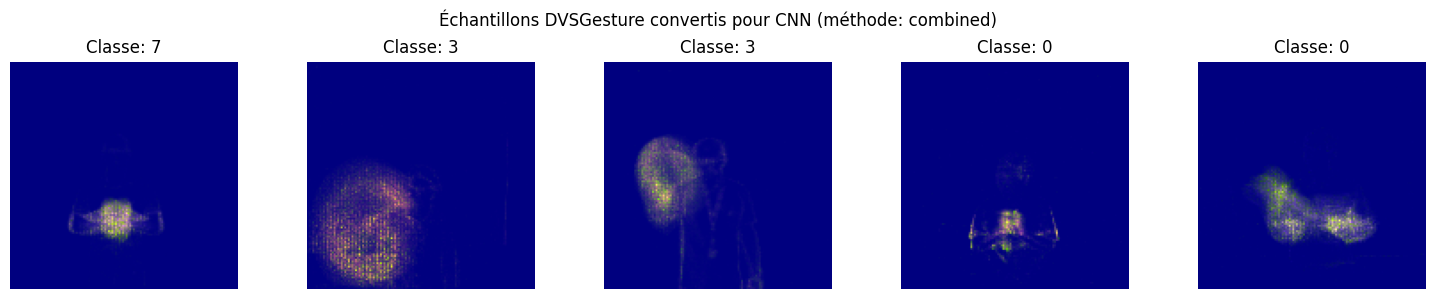

In [27]:
def visualize_cnn_samples(dataloader, method, num_samples=5):
    """Visualise quelques échantillons du dataloader pour CNN"""
    images, labels = next(iter(dataloader))
    
    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        image = images[i].numpy()  # (C, H, W)
        
        if method == 'combined':
            # Image RGB
            img = np.transpose(image, (1, 2, 0))
            axes[i].imshow(img)#np.clip(img, 0, 1))
        else:
            # Image en niveaux de gris
            axes[i].imshow(image[0], cmap='coolwarm', vmin=-1, vmax=1)
        
        axes[i].set_title(f"Classe: {labels[i].item()}")
        axes[i].axis('off')
    
    plt.suptitle(f"Échantillons DVSGesture convertis pour CNN (méthode: {method})")
    plt.tight_layout()
    plt.show()
visualize_cnn_samples(train_data_loader, method='combined', num_samples=5)

In [28]:
net = Reactnet(num_classes=Targetnum, imagenet=False)

In [29]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.

Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [30]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [31]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.cuda()
            label = label.cuda()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [32]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.cuda()
        label = label.cuda()
        
        out_fr = net(img)
        loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        loss.backward()

        parameters_list = []
        for name, p in net.named_parameters():
            if not 'fc' in name:
                parameters_list.append(p)
        adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
        optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [33]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


epoch=0, train_acc_top1=0.1040, train_acc_top5=0.4540, train_loss=13.7157, test_top1=0.0909, test_top5=0.4621, test_loss=11.1958, max_test_acc=0.0909, total_time=8.8061, LR=0.00100000


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


epoch=1, train_acc_top1=0.1077, train_acc_top5=0.4670, train_loss=8.8358, test_top1=0.0909, test_top5=0.4545, test_loss=7.3722, max_test_acc=0.0909, total_time=7.6088, LR=0.00099609


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


epoch=2, train_acc_top1=0.1123, train_acc_top5=0.4754, train_loss=7.2576, test_top1=0.0606, test_top5=0.4583, test_loss=7.8166, max_test_acc=0.0909, total_time=7.2055, LR=0.00099219


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


epoch=3, train_acc_top1=0.0956, train_acc_top5=0.4299, train_loss=5.8790, test_top1=0.1250, test_top5=0.5341, test_loss=4.8963, max_test_acc=0.1250, total_time=7.0613, LR=0.00098828


100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


epoch=4, train_acc_top1=0.1096, train_acc_top5=0.5506, train_loss=5.4948, test_top1=0.0909, test_top5=0.4545, test_loss=10.3232, max_test_acc=0.1250, total_time=7.1803, LR=0.00098438


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


epoch=5, train_acc_top1=0.0975, train_acc_top5=0.4745, train_loss=4.9776, test_top1=0.0758, test_top5=0.5303, test_loss=3.5394, max_test_acc=0.1250, total_time=7.0852, LR=0.00098047


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


epoch=6, train_acc_top1=0.0966, train_acc_top5=0.5320, train_loss=4.3784, test_top1=0.1705, test_top5=0.6515, test_loss=3.0714, max_test_acc=0.1705, total_time=7.5923, LR=0.00097656


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


epoch=7, train_acc_top1=0.1532, train_acc_top5=0.6035, train_loss=2.9345, test_top1=0.1023, test_top5=0.7348, test_loss=2.7371, max_test_acc=0.1705, total_time=7.3778, LR=0.00097266


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


epoch=8, train_acc_top1=0.1411, train_acc_top5=0.5970, train_loss=3.7277, test_top1=0.1515, test_top5=0.6136, test_loss=2.6414, max_test_acc=0.1705, total_time=7.6286, LR=0.00096875


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


epoch=9, train_acc_top1=0.0984, train_acc_top5=0.5079, train_loss=4.0369, test_top1=0.0909, test_top5=0.4621, test_loss=2.9141, max_test_acc=0.1705, total_time=8.3341, LR=0.00096484


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch=10, train_acc_top1=0.0919, train_acc_top5=0.5125, train_loss=3.3631, test_top1=0.1667, test_top5=0.6098, test_loss=2.5275, max_test_acc=0.1705, total_time=8.3164, LR=0.00096094


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


epoch=11, train_acc_top1=0.1263, train_acc_top5=0.5812, train_loss=3.0893, test_top1=0.0909, test_top5=0.4773, test_loss=5.8341, max_test_acc=0.1705, total_time=8.0921, LR=0.00095703


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


epoch=12, train_acc_top1=0.1086, train_acc_top5=0.5060, train_loss=3.1578, test_top1=0.1591, test_top5=0.5947, test_loss=2.4121, max_test_acc=0.1705, total_time=8.3283, LR=0.00095312


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


epoch=13, train_acc_top1=0.1031, train_acc_top5=0.5237, train_loss=2.9608, test_top1=0.0909, test_top5=0.5152, test_loss=3.0253, max_test_acc=0.1705, total_time=8.0487, LR=0.00094922


100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


epoch=14, train_acc_top1=0.1337, train_acc_top5=0.6175, train_loss=2.5122, test_top1=0.0720, test_top5=0.7121, test_loss=2.6019, max_test_acc=0.1705, total_time=8.3411, LR=0.00094531


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch=15, train_acc_top1=0.1328, train_acc_top5=0.5803, train_loss=3.4510, test_top1=0.2727, test_top5=0.7614, test_loss=2.1109, max_test_acc=0.2727, total_time=9.1467, LR=0.00094141


100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


epoch=16, train_acc_top1=0.1718, train_acc_top5=0.6351, train_loss=2.8510, test_top1=0.1780, test_top5=0.6553, test_loss=2.4488, max_test_acc=0.2727, total_time=8.3365, LR=0.00093750


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


epoch=17, train_acc_top1=0.1959, train_acc_top5=0.7205, train_loss=2.3116, test_top1=0.2273, test_top5=0.7197, test_loss=2.2072, max_test_acc=0.2727, total_time=8.8678, LR=0.00093359


100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


epoch=18, train_acc_top1=0.1968, train_acc_top5=0.7103, train_loss=2.2589, test_top1=0.2955, test_top5=0.7955, test_loss=1.9651, max_test_acc=0.2955, total_time=9.0360, LR=0.00092969


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


epoch=19, train_acc_top1=0.2813, train_acc_top5=0.7902, train_loss=1.9789, test_top1=0.3106, test_top5=0.9015, test_loss=1.6654, max_test_acc=0.3106, total_time=9.1550, LR=0.00092578


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


epoch=20, train_acc_top1=0.2572, train_acc_top5=0.8097, train_loss=2.0834, test_top1=0.2614, test_top5=0.7955, test_loss=2.1870, max_test_acc=0.3106, total_time=8.4482, LR=0.00092188


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


epoch=21, train_acc_top1=0.1922, train_acc_top5=0.6732, train_loss=2.6657, test_top1=0.2727, test_top5=0.8409, test_loss=2.1176, max_test_acc=0.3106, total_time=8.8611, LR=0.00091797


100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


epoch=22, train_acc_top1=0.2618, train_acc_top5=0.7400, train_loss=2.3733, test_top1=0.3144, test_top5=0.6818, test_loss=2.1401, max_test_acc=0.3144, total_time=8.7341, LR=0.00091406


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch=23, train_acc_top1=0.2312, train_acc_top5=0.6825, train_loss=2.2561, test_top1=0.1061, test_top5=0.5530, test_loss=4.2913, max_test_acc=0.3144, total_time=8.0452, LR=0.00091016


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


epoch=24, train_acc_top1=0.2758, train_acc_top5=0.7567, train_loss=2.2305, test_top1=0.3712, test_top5=0.9205, test_loss=1.5376, max_test_acc=0.3712, total_time=8.2346, LR=0.00090625


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


epoch=25, train_acc_top1=0.3435, train_acc_top5=0.8663, train_loss=1.8348, test_top1=0.3220, test_top5=0.8447, test_loss=1.7983, max_test_acc=0.3712, total_time=7.4266, LR=0.00090234


100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


epoch=26, train_acc_top1=0.3454, train_acc_top5=0.8663, train_loss=1.7877, test_top1=0.5076, test_top5=0.9697, test_loss=1.2083, max_test_acc=0.5076, total_time=7.5837, LR=0.00089844


100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


epoch=27, train_acc_top1=0.4280, train_acc_top5=0.8886, train_loss=1.9268, test_top1=0.3220, test_top5=0.8333, test_loss=2.0589, max_test_acc=0.5076, total_time=7.5276, LR=0.00089453


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


epoch=28, train_acc_top1=0.4420, train_acc_top5=0.9211, train_loss=1.5306, test_top1=0.5341, test_top5=0.9432, test_loss=1.2698, max_test_acc=0.5341, total_time=7.7320, LR=0.00089063


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


epoch=29, train_acc_top1=0.4605, train_acc_top5=0.9378, train_loss=1.4291, test_top1=0.5114, test_top5=0.9015, test_loss=1.4650, max_test_acc=0.5341, total_time=7.0432, LR=0.00088672


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


epoch=30, train_acc_top1=0.4383, train_acc_top5=0.9099, train_loss=1.5068, test_top1=0.5455, test_top5=1.0000, test_loss=1.0729, max_test_acc=0.5455, total_time=9.7253, LR=0.00088281


100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


epoch=31, train_acc_top1=0.5088, train_acc_top5=0.9749, train_loss=1.2228, test_top1=0.5985, test_top5=0.9735, test_loss=1.0267, max_test_acc=0.5985, total_time=9.4476, LR=0.00087891


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


epoch=32, train_acc_top1=0.4550, train_acc_top5=0.8635, train_loss=1.9889, test_top1=0.3523, test_top5=0.8712, test_loss=1.7173, max_test_acc=0.5985, total_time=8.4680, LR=0.00087500


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


epoch=33, train_acc_top1=0.4095, train_acc_top5=0.9229, train_loss=1.4688, test_top1=0.5871, test_top5=0.9773, test_loss=1.0894, max_test_acc=0.5985, total_time=8.4997, LR=0.00087109


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


epoch=34, train_acc_top1=0.4940, train_acc_top5=0.9239, train_loss=1.3966, test_top1=0.5417, test_top5=0.9659, test_loss=1.0649, max_test_acc=0.5985, total_time=8.9950, LR=0.00086719


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


epoch=35, train_acc_top1=0.6045, train_acc_top5=0.9870, train_loss=1.0135, test_top1=0.6326, test_top5=0.9735, test_loss=0.9780, max_test_acc=0.6326, total_time=9.4470, LR=0.00086328


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


epoch=36, train_acc_top1=0.6184, train_acc_top5=0.9861, train_loss=0.9336, test_top1=0.5455, test_top5=0.9621, test_loss=1.1823, max_test_acc=0.6326, total_time=7.3642, LR=0.00085938


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


epoch=37, train_acc_top1=0.5905, train_acc_top5=0.9879, train_loss=0.9809, test_top1=0.6402, test_top5=0.9583, test_loss=1.0260, max_test_acc=0.6402, total_time=8.2376, LR=0.00085547


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


epoch=38, train_acc_top1=0.6741, train_acc_top5=0.9907, train_loss=0.7711, test_top1=0.7121, test_top5=0.9848, test_loss=0.7783, max_test_acc=0.7121, total_time=7.3346, LR=0.00085156


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


epoch=39, train_acc_top1=0.6351, train_acc_top5=0.9786, train_loss=1.0518, test_top1=0.1667, test_top5=0.5644, test_loss=8.8431, max_test_acc=0.7121, total_time=7.0572, LR=0.00084766


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


epoch=40, train_acc_top1=0.4661, train_acc_top5=0.8635, train_loss=2.4179, test_top1=0.5114, test_top5=0.9053, test_loss=1.4285, max_test_acc=0.7121, total_time=7.2540, LR=0.00084375


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch=41, train_acc_top1=0.5283, train_acc_top5=0.9499, train_loss=1.2418, test_top1=0.5833, test_top5=0.9659, test_loss=1.0126, max_test_acc=0.7121, total_time=7.9861, LR=0.00083984


100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


epoch=42, train_acc_top1=0.6527, train_acc_top5=0.9972, train_loss=0.8527, test_top1=0.7008, test_top5=0.9886, test_loss=0.7129, max_test_acc=0.7121, total_time=7.5164, LR=0.00083594


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch=43, train_acc_top1=0.6193, train_acc_top5=0.9861, train_loss=0.9415, test_top1=0.5833, test_top5=0.9848, test_loss=1.0529, max_test_acc=0.7121, total_time=7.8853, LR=0.00083203


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


epoch=44, train_acc_top1=0.6843, train_acc_top5=0.9889, train_loss=0.7994, test_top1=0.6780, test_top5=0.9735, test_loss=0.8491, max_test_acc=0.7121, total_time=6.7607, LR=0.00082812


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


epoch=45, train_acc_top1=0.6555, train_acc_top5=0.9898, train_loss=0.8349, test_top1=0.6742, test_top5=0.9848, test_loss=0.8174, max_test_acc=0.7121, total_time=7.4990, LR=0.00082422


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


epoch=46, train_acc_top1=0.7344, train_acc_top5=0.9954, train_loss=0.6900, test_top1=0.5000, test_top5=0.9356, test_loss=1.3461, max_test_acc=0.7121, total_time=7.5910, LR=0.00082031


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


epoch=47, train_acc_top1=0.5961, train_acc_top5=0.9759, train_loss=1.0892, test_top1=0.6970, test_top5=0.9735, test_loss=0.9159, max_test_acc=0.7121, total_time=6.9621, LR=0.00081641


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


epoch=48, train_acc_top1=0.7270, train_acc_top5=0.9944, train_loss=0.6880, test_top1=0.7008, test_top5=0.9773, test_loss=0.8064, max_test_acc=0.7121, total_time=6.7950, LR=0.00081250


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


epoch=49, train_acc_top1=0.7289, train_acc_top5=0.9963, train_loss=0.7136, test_top1=0.6364, test_top5=1.0000, test_loss=0.9342, max_test_acc=0.7121, total_time=6.6773, LR=0.00080859


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


epoch=50, train_acc_top1=0.7326, train_acc_top5=0.9954, train_loss=0.6732, test_top1=0.7121, test_top5=0.9886, test_loss=0.7267, max_test_acc=0.7121, total_time=7.0541, LR=0.00080469


100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


epoch=51, train_acc_top1=0.6630, train_acc_top5=0.9833, train_loss=0.9166, test_top1=0.6705, test_top5=0.9848, test_loss=0.8157, max_test_acc=0.7121, total_time=7.3853, LR=0.00080078


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


epoch=52, train_acc_top1=0.6982, train_acc_top5=0.9981, train_loss=0.7375, test_top1=0.7424, test_top5=0.9962, test_loss=0.7211, max_test_acc=0.7424, total_time=10.1825, LR=0.00079688


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


epoch=53, train_acc_top1=0.7809, train_acc_top5=0.9963, train_loss=0.5778, test_top1=0.7008, test_top5=0.9811, test_loss=0.8016, max_test_acc=0.7424, total_time=8.8918, LR=0.00079297


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


epoch=54, train_acc_top1=0.8022, train_acc_top5=0.9991, train_loss=0.5082, test_top1=0.7614, test_top5=0.9962, test_loss=0.6056, max_test_acc=0.7614, total_time=8.2903, LR=0.00078906


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


epoch=55, train_acc_top1=0.8329, train_acc_top5=0.9981, train_loss=0.4659, test_top1=0.7917, test_top5=1.0000, test_loss=0.5355, max_test_acc=0.7917, total_time=9.6979, LR=0.00078516


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


epoch=56, train_acc_top1=0.8617, train_acc_top5=0.9981, train_loss=0.4031, test_top1=0.8068, test_top5=1.0000, test_loss=0.5066, max_test_acc=0.8068, total_time=9.7900, LR=0.00078125


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


epoch=57, train_acc_top1=0.8747, train_acc_top5=0.9991, train_loss=0.3679, test_top1=0.7765, test_top5=1.0000, test_loss=0.5453, max_test_acc=0.8068, total_time=7.2195, LR=0.00077734


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch=58, train_acc_top1=0.8097, train_acc_top5=0.9935, train_loss=0.5145, test_top1=0.7652, test_top5=0.9924, test_loss=0.6327, max_test_acc=0.8068, total_time=7.7092, LR=0.00077344


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


epoch=59, train_acc_top1=0.8375, train_acc_top5=0.9972, train_loss=0.4215, test_top1=0.8030, test_top5=1.0000, test_loss=0.5797, max_test_acc=0.8068, total_time=8.5339, LR=0.00076953


100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


epoch=60, train_acc_top1=0.8895, train_acc_top5=0.9972, train_loss=0.3454, test_top1=0.7765, test_top5=0.9924, test_loss=0.5621, max_test_acc=0.8068, total_time=7.7231, LR=0.00076563


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


epoch=61, train_acc_top1=0.8802, train_acc_top5=0.9991, train_loss=0.3420, test_top1=0.8144, test_top5=1.0000, test_loss=0.5003, max_test_acc=0.8144, total_time=8.1042, LR=0.00076172


100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


epoch=62, train_acc_top1=0.8904, train_acc_top5=0.9981, train_loss=0.3247, test_top1=0.6932, test_top5=0.9848, test_loss=1.0202, max_test_acc=0.8144, total_time=7.8535, LR=0.00075781


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch=63, train_acc_top1=0.8709, train_acc_top5=1.0000, train_loss=0.3601, test_top1=0.8295, test_top5=1.0000, test_loss=0.5050, max_test_acc=0.8295, total_time=8.3204, LR=0.00075391


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch=64, train_acc_top1=0.8988, train_acc_top5=0.9991, train_loss=0.3014, test_top1=0.7727, test_top5=0.9848, test_loss=0.6961, max_test_acc=0.8295, total_time=7.7926, LR=0.00075000


100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


epoch=65, train_acc_top1=0.8747, train_acc_top5=0.9991, train_loss=0.3361, test_top1=0.7235, test_top5=0.9811, test_loss=0.7044, max_test_acc=0.8295, total_time=7.5381, LR=0.00074609


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=66, train_acc_top1=0.8997, train_acc_top5=0.9991, train_loss=0.2804, test_top1=0.8220, test_top5=1.0000, test_loss=0.5002, max_test_acc=0.8295, total_time=7.4132, LR=0.00074219


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


epoch=67, train_acc_top1=0.8951, train_acc_top5=0.9981, train_loss=0.2945, test_top1=0.8030, test_top5=0.9924, test_loss=0.5564, max_test_acc=0.8295, total_time=8.0158, LR=0.00073828


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


epoch=68, train_acc_top1=0.8802, train_acc_top5=1.0000, train_loss=0.3825, test_top1=0.8144, test_top5=0.9924, test_loss=0.6166, max_test_acc=0.8295, total_time=7.3929, LR=0.00073438


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


epoch=69, train_acc_top1=0.8635, train_acc_top5=0.9991, train_loss=0.3651, test_top1=0.8030, test_top5=1.0000, test_loss=0.5447, max_test_acc=0.8295, total_time=7.6490, LR=0.00073047


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


epoch=70, train_acc_top1=0.9062, train_acc_top5=0.9981, train_loss=0.3109, test_top1=0.8371, test_top5=0.9886, test_loss=0.5193, max_test_acc=0.8371, total_time=7.3585, LR=0.00072656


100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


epoch=71, train_acc_top1=0.9109, train_acc_top5=0.9981, train_loss=0.2826, test_top1=0.7917, test_top5=0.9924, test_loss=0.6664, max_test_acc=0.8371, total_time=7.5185, LR=0.00072266


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=72, train_acc_top1=0.8839, train_acc_top5=0.9981, train_loss=0.3443, test_top1=0.7348, test_top5=1.0000, test_loss=0.6790, max_test_acc=0.8371, total_time=7.7778, LR=0.00071875


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


epoch=73, train_acc_top1=0.8756, train_acc_top5=0.9991, train_loss=0.3449, test_top1=0.7992, test_top5=1.0000, test_loss=0.7025, max_test_acc=0.8371, total_time=7.1966, LR=0.00071484


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


epoch=74, train_acc_top1=0.4847, train_acc_top5=0.8319, train_loss=2.7050, test_top1=0.5000, test_top5=0.9394, test_loss=1.4695, max_test_acc=0.8371, total_time=7.3122, LR=0.00071094


100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


epoch=75, train_acc_top1=0.7279, train_acc_top5=0.9935, train_loss=0.7086, test_top1=0.7273, test_top5=1.0000, test_loss=0.6606, max_test_acc=0.8371, total_time=7.4053, LR=0.00070703


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


epoch=76, train_acc_top1=0.8579, train_acc_top5=0.9981, train_loss=0.4193, test_top1=0.7652, test_top5=0.9924, test_loss=0.7608, max_test_acc=0.8371, total_time=7.0086, LR=0.00070312


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


epoch=77, train_acc_top1=0.8654, train_acc_top5=0.9981, train_loss=0.3639, test_top1=0.7197, test_top5=0.9924, test_loss=0.7799, max_test_acc=0.8371, total_time=7.1451, LR=0.00069922


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


epoch=78, train_acc_top1=0.8737, train_acc_top5=1.0000, train_loss=0.3215, test_top1=0.7727, test_top5=1.0000, test_loss=0.5816, max_test_acc=0.8371, total_time=7.2419, LR=0.00069531


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


epoch=79, train_acc_top1=0.8932, train_acc_top5=0.9981, train_loss=0.3136, test_top1=0.7689, test_top5=0.9848, test_loss=0.6484, max_test_acc=0.8371, total_time=6.8366, LR=0.00069141


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


epoch=80, train_acc_top1=0.9331, train_acc_top5=1.0000, train_loss=0.2278, test_top1=0.8068, test_top5=0.9962, test_loss=0.5337, max_test_acc=0.8371, total_time=7.0382, LR=0.00068750


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch=81, train_acc_top1=0.9424, train_acc_top5=1.0000, train_loss=0.1920, test_top1=0.8220, test_top5=1.0000, test_loss=0.4860, max_test_acc=0.8371, total_time=8.4249, LR=0.00068359


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


epoch=82, train_acc_top1=0.9424, train_acc_top5=1.0000, train_loss=0.1865, test_top1=0.7689, test_top5=0.9962, test_loss=0.6261, max_test_acc=0.8371, total_time=8.7512, LR=0.00067969


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


epoch=83, train_acc_top1=0.9211, train_acc_top5=0.9991, train_loss=0.2398, test_top1=0.8258, test_top5=0.9962, test_loss=0.5469, max_test_acc=0.8371, total_time=8.8920, LR=0.00067578


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


epoch=84, train_acc_top1=0.9285, train_acc_top5=1.0000, train_loss=0.2080, test_top1=0.7841, test_top5=0.9924, test_loss=0.6612, max_test_acc=0.8371, total_time=8.8493, LR=0.00067188


100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


epoch=85, train_acc_top1=0.9387, train_acc_top5=1.0000, train_loss=0.1803, test_top1=0.8068, test_top5=0.9848, test_loss=0.6501, max_test_acc=0.8371, total_time=8.5198, LR=0.00066797


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


epoch=86, train_acc_top1=0.9508, train_acc_top5=1.0000, train_loss=0.1612, test_top1=0.7765, test_top5=0.9886, test_loss=0.6328, max_test_acc=0.8371, total_time=8.8686, LR=0.00066406


100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


epoch=87, train_acc_top1=0.9248, train_acc_top5=1.0000, train_loss=0.2137, test_top1=0.8333, test_top5=0.9962, test_loss=0.5071, max_test_acc=0.8371, total_time=8.1423, LR=0.00066016


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


epoch=88, train_acc_top1=0.9461, train_acc_top5=1.0000, train_loss=0.1518, test_top1=0.8220, test_top5=1.0000, test_loss=0.5580, max_test_acc=0.8371, total_time=8.6184, LR=0.00065625


100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


epoch=89, train_acc_top1=0.9415, train_acc_top5=1.0000, train_loss=0.1785, test_top1=0.8030, test_top5=1.0000, test_loss=0.6391, max_test_acc=0.8371, total_time=7.7907, LR=0.00065234


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


epoch=90, train_acc_top1=0.9666, train_acc_top5=1.0000, train_loss=0.1210, test_top1=0.8182, test_top5=1.0000, test_loss=0.5757, max_test_acc=0.8371, total_time=7.8818, LR=0.00064844


100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


epoch=91, train_acc_top1=0.9666, train_acc_top5=1.0000, train_loss=0.1089, test_top1=0.7992, test_top5=1.0000, test_loss=0.6947, max_test_acc=0.8371, total_time=8.2567, LR=0.00064453


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


epoch=92, train_acc_top1=0.9136, train_acc_top5=0.9954, train_loss=0.2934, test_top1=0.7652, test_top5=0.9924, test_loss=0.8045, max_test_acc=0.8371, total_time=7.7792, LR=0.00064063


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


epoch=93, train_acc_top1=0.9489, train_acc_top5=1.0000, train_loss=0.1545, test_top1=0.8106, test_top5=1.0000, test_loss=0.5806, max_test_acc=0.8371, total_time=7.2724, LR=0.00063672


100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


epoch=94, train_acc_top1=0.9703, train_acc_top5=1.0000, train_loss=0.1204, test_top1=0.8333, test_top5=0.9962, test_loss=0.5939, max_test_acc=0.8371, total_time=7.7122, LR=0.00063281


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


epoch=95, train_acc_top1=0.9601, train_acc_top5=1.0000, train_loss=0.1280, test_top1=0.8182, test_top5=0.9962, test_loss=0.5947, max_test_acc=0.8371, total_time=7.7938, LR=0.00062891


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


epoch=96, train_acc_top1=0.9591, train_acc_top5=0.9991, train_loss=0.1265, test_top1=0.8258, test_top5=1.0000, test_loss=0.6430, max_test_acc=0.8371, total_time=7.9575, LR=0.00062500


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch=97, train_acc_top1=0.9285, train_acc_top5=1.0000, train_loss=0.2087, test_top1=0.7917, test_top5=0.9886, test_loss=0.6880, max_test_acc=0.8371, total_time=8.0573, LR=0.00062109


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


epoch=98, train_acc_top1=0.9656, train_acc_top5=1.0000, train_loss=0.1285, test_top1=0.7879, test_top5=0.9962, test_loss=0.6943, max_test_acc=0.8371, total_time=8.5909, LR=0.00061719


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch=99, train_acc_top1=0.9610, train_acc_top5=0.9991, train_loss=0.1131, test_top1=0.8220, test_top5=0.9962, test_loss=0.5890, max_test_acc=0.8371, total_time=8.4566, LR=0.00061328


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


epoch=100, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0786, test_top1=0.8144, test_top5=0.9886, test_loss=0.6034, max_test_acc=0.8371, total_time=7.8704, LR=0.00060937


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch=101, train_acc_top1=0.9647, train_acc_top5=1.0000, train_loss=0.1116, test_top1=0.8371, test_top5=0.9962, test_loss=0.5813, max_test_acc=0.8371, total_time=8.9195, LR=0.00060547


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


epoch=102, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0549, test_top1=0.8258, test_top5=1.0000, test_loss=0.6190, max_test_acc=0.8371, total_time=7.8391, LR=0.00060156


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


epoch=103, train_acc_top1=0.9721, train_acc_top5=1.0000, train_loss=0.0841, test_top1=0.7955, test_top5=0.9924, test_loss=0.8804, max_test_acc=0.8371, total_time=6.5721, LR=0.00059766


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


epoch=104, train_acc_top1=0.9694, train_acc_top5=1.0000, train_loss=0.0993, test_top1=0.8182, test_top5=0.9962, test_loss=0.6405, max_test_acc=0.8371, total_time=6.6024, LR=0.00059375


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


epoch=105, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0578, test_top1=0.8485, test_top5=0.9962, test_loss=0.6202, max_test_acc=0.8485, total_time=6.8909, LR=0.00058984


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=106, train_acc_top1=0.9786, train_acc_top5=0.9991, train_loss=0.0820, test_top1=0.8409, test_top5=0.9924, test_loss=0.5677, max_test_acc=0.8485, total_time=6.4273, LR=0.00058594


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


epoch=107, train_acc_top1=0.9378, train_acc_top5=0.9981, train_loss=0.2209, test_top1=0.8523, test_top5=1.0000, test_loss=0.5199, max_test_acc=0.8523, total_time=7.4508, LR=0.00058203


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=108, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0710, test_top1=0.8371, test_top5=1.0000, test_loss=0.5352, max_test_acc=0.8523, total_time=6.4673, LR=0.00057812


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=109, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0624, test_top1=0.8182, test_top5=0.9886, test_loss=0.6648, max_test_acc=0.8523, total_time=6.4529, LR=0.00057422


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


epoch=110, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0778, test_top1=0.8220, test_top5=0.9886, test_loss=0.7056, max_test_acc=0.8523, total_time=6.4331, LR=0.00057031


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


epoch=111, train_acc_top1=0.9610, train_acc_top5=1.0000, train_loss=0.1177, test_top1=0.8030, test_top5=0.9962, test_loss=0.7178, max_test_acc=0.8523, total_time=6.4227, LR=0.00056641


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=112, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0827, test_top1=0.8144, test_top5=1.0000, test_loss=0.5926, max_test_acc=0.8523, total_time=6.4451, LR=0.00056250


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=113, train_acc_top1=0.9851, train_acc_top5=1.0000, train_loss=0.0701, test_top1=0.8182, test_top5=1.0000, test_loss=0.7011, max_test_acc=0.8523, total_time=6.4024, LR=0.00055859


100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


epoch=114, train_acc_top1=0.9526, train_acc_top5=0.9926, train_loss=0.1919, test_top1=0.8371, test_top5=1.0000, test_loss=0.6904, max_test_acc=0.8523, total_time=6.3817, LR=0.00055469


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=115, train_acc_top1=0.9870, train_acc_top5=1.0000, train_loss=0.0606, test_top1=0.8333, test_top5=1.0000, test_loss=0.6174, max_test_acc=0.8523, total_time=6.4425, LR=0.00055078


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=116, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0525, test_top1=0.8144, test_top5=1.0000, test_loss=0.6049, max_test_acc=0.8523, total_time=6.4707, LR=0.00054688


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=117, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0614, test_top1=0.8030, test_top5=0.9848, test_loss=0.8118, max_test_acc=0.8523, total_time=6.4591, LR=0.00054297


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=118, train_acc_top1=0.9387, train_acc_top5=0.9879, train_loss=0.3866, test_top1=0.8674, test_top5=0.9962, test_loss=0.5287, max_test_acc=0.8674, total_time=8.2392, LR=0.00053906


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


epoch=119, train_acc_top1=0.9174, train_acc_top5=1.0000, train_loss=0.2288, test_top1=0.7841, test_top5=0.9924, test_loss=0.7266, max_test_acc=0.8674, total_time=6.5102, LR=0.00053516


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=120, train_acc_top1=0.9545, train_acc_top5=1.0000, train_loss=0.1476, test_top1=0.7955, test_top5=0.9811, test_loss=0.8140, max_test_acc=0.8674, total_time=6.5058, LR=0.00053125


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=121, train_acc_top1=0.9647, train_acc_top5=1.0000, train_loss=0.1063, test_top1=0.8144, test_top5=1.0000, test_loss=0.6803, max_test_acc=0.8674, total_time=6.4397, LR=0.00052734


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


epoch=122, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0470, test_top1=0.8030, test_top5=0.9848, test_loss=0.6601, max_test_acc=0.8674, total_time=6.4243, LR=0.00052344


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=123, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0350, test_top1=0.8409, test_top5=0.9962, test_loss=0.6540, max_test_acc=0.8674, total_time=6.4413, LR=0.00051953


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=124, train_acc_top1=0.9675, train_acc_top5=1.0000, train_loss=0.1095, test_top1=0.8447, test_top5=0.9962, test_loss=0.5459, max_test_acc=0.8674, total_time=6.4823, LR=0.00051563


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=125, train_acc_top1=0.9712, train_acc_top5=1.0000, train_loss=0.0998, test_top1=0.8182, test_top5=0.9924, test_loss=0.8015, max_test_acc=0.8674, total_time=6.4448, LR=0.00051172


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=126, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0467, test_top1=0.8485, test_top5=1.0000, test_loss=0.5387, max_test_acc=0.8674, total_time=6.4672, LR=0.00050781


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=127, train_acc_top1=0.9935, train_acc_top5=1.0000, train_loss=0.0389, test_top1=0.8144, test_top5=1.0000, test_loss=0.6876, max_test_acc=0.8674, total_time=6.5065, LR=0.00050391


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


epoch=128, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0506, test_top1=0.8295, test_top5=0.9962, test_loss=0.6051, max_test_acc=0.8674, total_time=6.4768, LR=0.00050000


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


epoch=129, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0189, test_top1=0.8106, test_top5=1.0000, test_loss=0.6904, max_test_acc=0.8674, total_time=6.4980, LR=0.00049609


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


epoch=130, train_acc_top1=0.9935, train_acc_top5=1.0000, train_loss=0.0284, test_top1=0.8523, test_top5=0.9924, test_loss=0.6288, max_test_acc=0.8674, total_time=6.4585, LR=0.00049219


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=131, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0225, test_top1=0.8182, test_top5=1.0000, test_loss=0.6665, max_test_acc=0.8674, total_time=6.4868, LR=0.00048828


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


epoch=132, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0379, test_top1=0.8333, test_top5=0.9962, test_loss=0.5508, max_test_acc=0.8674, total_time=6.4543, LR=0.00048437


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=133, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0273, test_top1=0.8220, test_top5=0.9962, test_loss=0.7228, max_test_acc=0.8674, total_time=6.5145, LR=0.00048047


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


epoch=134, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0233, test_top1=0.8409, test_top5=0.9886, test_loss=0.6792, max_test_acc=0.8674, total_time=6.4377, LR=0.00047656


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=135, train_acc_top1=0.9703, train_acc_top5=1.0000, train_loss=0.0982, test_top1=0.7727, test_top5=0.9848, test_loss=1.0066, max_test_acc=0.8674, total_time=6.4239, LR=0.00047266


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=136, train_acc_top1=0.9749, train_acc_top5=0.9991, train_loss=0.0744, test_top1=0.8409, test_top5=0.9962, test_loss=0.5682, max_test_acc=0.8674, total_time=6.4074, LR=0.00046875


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=137, train_acc_top1=0.9963, train_acc_top5=1.0000, train_loss=0.0251, test_top1=0.6780, test_top5=0.9773, test_loss=1.0305, max_test_acc=0.8674, total_time=6.4184, LR=0.00046484


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


epoch=138, train_acc_top1=0.9582, train_acc_top5=0.9981, train_loss=0.1370, test_top1=0.8447, test_top5=0.9848, test_loss=0.6398, max_test_acc=0.8674, total_time=6.4024, LR=0.00046094


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=139, train_acc_top1=0.9731, train_acc_top5=1.0000, train_loss=0.0821, test_top1=0.8106, test_top5=0.9962, test_loss=0.7393, max_test_acc=0.8674, total_time=6.4769, LR=0.00045703


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


epoch=140, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0361, test_top1=0.8371, test_top5=1.0000, test_loss=0.5726, max_test_acc=0.8674, total_time=6.4806, LR=0.00045313


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=141, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0179, test_top1=0.8485, test_top5=1.0000, test_loss=0.6119, max_test_acc=0.8674, total_time=6.4472, LR=0.00044922


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


epoch=142, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0146, test_top1=0.8333, test_top5=0.9924, test_loss=0.6785, max_test_acc=0.8674, total_time=6.3967, LR=0.00044531


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


epoch=143, train_acc_top1=0.9731, train_acc_top5=0.9991, train_loss=0.0922, test_top1=0.8030, test_top5=0.9886, test_loss=0.7219, max_test_acc=0.8674, total_time=6.4622, LR=0.00044141


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=144, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0430, test_top1=0.7917, test_top5=0.9886, test_loss=0.7636, max_test_acc=0.8674, total_time=6.4074, LR=0.00043750


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


epoch=145, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0374, test_top1=0.8144, test_top5=0.9924, test_loss=0.6575, max_test_acc=0.8674, total_time=6.4251, LR=0.00043359


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


epoch=146, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0154, test_top1=0.8371, test_top5=0.9924, test_loss=0.6386, max_test_acc=0.8674, total_time=6.4713, LR=0.00042969


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=147, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0074, test_top1=0.8409, test_top5=0.9924, test_loss=0.6926, max_test_acc=0.8674, total_time=6.4297, LR=0.00042578


100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


epoch=148, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0055, test_top1=0.8561, test_top5=1.0000, test_loss=0.5937, max_test_acc=0.8674, total_time=6.3997, LR=0.00042187


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=149, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0038, test_top1=0.8523, test_top5=0.9924, test_loss=0.6469, max_test_acc=0.8674, total_time=6.4561, LR=0.00041797


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=150, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0035, test_top1=0.8409, test_top5=0.9924, test_loss=0.6886, max_test_acc=0.8674, total_time=6.4349, LR=0.00041406


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


epoch=151, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0030, test_top1=0.8485, test_top5=0.9924, test_loss=0.6777, max_test_acc=0.8674, total_time=6.4430, LR=0.00041016


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


epoch=152, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0028, test_top1=0.8523, test_top5=0.9924, test_loss=0.7244, max_test_acc=0.8674, total_time=6.4049, LR=0.00040625


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


epoch=153, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0025, test_top1=0.8485, test_top5=0.9962, test_loss=0.6605, max_test_acc=0.8674, total_time=6.4706, LR=0.00040234


100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


epoch=154, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0039, test_top1=0.8598, test_top5=0.9962, test_loss=0.6456, max_test_acc=0.8674, total_time=6.3963, LR=0.00039844


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=155, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0023, test_top1=0.8598, test_top5=0.9962, test_loss=0.6887, max_test_acc=0.8674, total_time=6.4120, LR=0.00039453


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=156, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0021, test_top1=0.8712, test_top5=0.9962, test_loss=0.6743, max_test_acc=0.8712, total_time=6.7116, LR=0.00039063


100%|██████████| 5/5 [00:01<00:00,  4.67it/s]


epoch=157, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0021, test_top1=0.8636, test_top5=0.9962, test_loss=0.6618, max_test_acc=0.8712, total_time=6.5776, LR=0.00038672


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=158, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0019, test_top1=0.8523, test_top5=0.9962, test_loss=0.6936, max_test_acc=0.8712, total_time=6.4247, LR=0.00038281


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


epoch=159, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0021, test_top1=0.8598, test_top5=0.9962, test_loss=0.6634, max_test_acc=0.8712, total_time=6.3850, LR=0.00037891


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=160, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.8674, test_top5=0.9924, test_loss=0.6855, max_test_acc=0.8712, total_time=6.4338, LR=0.00037500


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=161, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0031, test_top1=0.8750, test_top5=1.0000, test_loss=0.6681, max_test_acc=0.8750, total_time=6.8035, LR=0.00037109


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=162, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0029, test_top1=0.8561, test_top5=0.9962, test_loss=0.6659, max_test_acc=0.8750, total_time=6.4603, LR=0.00036719


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=163, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0028, test_top1=0.8447, test_top5=0.9924, test_loss=0.7830, max_test_acc=0.8750, total_time=6.4158, LR=0.00036328


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=164, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0025, test_top1=0.8561, test_top5=1.0000, test_loss=0.7050, max_test_acc=0.8750, total_time=6.4406, LR=0.00035937


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


epoch=165, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0033, test_top1=0.8485, test_top5=1.0000, test_loss=0.7307, max_test_acc=0.8750, total_time=6.4306, LR=0.00035547


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=166, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0035, test_top1=0.8674, test_top5=0.9886, test_loss=0.7090, max_test_acc=0.8750, total_time=6.4651, LR=0.00035156


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


epoch=167, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0041, test_top1=0.8485, test_top5=0.9924, test_loss=0.6664, max_test_acc=0.8750, total_time=6.4060, LR=0.00034766


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


epoch=168, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0106, test_top1=0.8447, test_top5=1.0000, test_loss=0.7434, max_test_acc=0.8750, total_time=6.3983, LR=0.00034375


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


epoch=169, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0169, test_top1=0.8333, test_top5=0.9924, test_loss=0.7001, max_test_acc=0.8750, total_time=6.3930, LR=0.00033984


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


epoch=170, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0090, test_top1=0.8561, test_top5=0.9962, test_loss=0.6253, max_test_acc=0.8750, total_time=6.4021, LR=0.00033594


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=171, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0047, test_top1=0.8447, test_top5=1.0000, test_loss=0.7254, max_test_acc=0.8750, total_time=6.4247, LR=0.00033203


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


epoch=172, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0028, test_top1=0.8561, test_top5=1.0000, test_loss=0.6476, max_test_acc=0.8750, total_time=6.4196, LR=0.00032813


100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


epoch=173, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0023, test_top1=0.8598, test_top5=1.0000, test_loss=0.6462, max_test_acc=0.8750, total_time=6.4146, LR=0.00032422


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=174, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0020, test_top1=0.8674, test_top5=1.0000, test_loss=0.6145, max_test_acc=0.8750, total_time=6.4154, LR=0.00032031


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=175, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0015, test_top1=0.8712, test_top5=0.9962, test_loss=0.6663, max_test_acc=0.8750, total_time=6.4055, LR=0.00031641


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=176, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0016, test_top1=0.8750, test_top5=0.9962, test_loss=0.6470, max_test_acc=0.8750, total_time=6.7927, LR=0.00031250


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=177, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0014, test_top1=0.8674, test_top5=0.9962, test_loss=0.6496, max_test_acc=0.8750, total_time=6.4556, LR=0.00030859


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=178, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.8674, test_top5=0.9962, test_loss=0.6616, max_test_acc=0.8750, total_time=6.4193, LR=0.00030469


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=179, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.8636, test_top5=1.0000, test_loss=0.6516, max_test_acc=0.8750, total_time=6.4069, LR=0.00030078


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


epoch=180, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.8636, test_top5=0.9924, test_loss=0.6484, max_test_acc=0.8750, total_time=6.4480, LR=0.00029687


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


epoch=181, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0016, test_top1=0.8636, test_top5=0.9962, test_loss=0.6883, max_test_acc=0.8750, total_time=6.4504, LR=0.00029297


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


epoch=182, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0021, test_top1=0.8598, test_top5=1.0000, test_loss=0.6585, max_test_acc=0.8750, total_time=6.5672, LR=0.00028906


100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


epoch=183, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.8674, test_top5=0.9924, test_loss=0.7413, max_test_acc=0.8750, total_time=6.4496, LR=0.00028516


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=184, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.8598, test_top5=0.9924, test_loss=0.6919, max_test_acc=0.8750, total_time=6.4668, LR=0.00028125


100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


epoch=185, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0017, test_top1=0.8523, test_top5=1.0000, test_loss=0.6564, max_test_acc=0.8750, total_time=6.4083, LR=0.00027734


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


epoch=186, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0016, test_top1=0.8636, test_top5=1.0000, test_loss=0.7118, max_test_acc=0.8750, total_time=6.4654, LR=0.00027344


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=187, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0014, test_top1=0.8598, test_top5=1.0000, test_loss=0.6547, max_test_acc=0.8750, total_time=6.4412, LR=0.00026953


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


epoch=188, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.8788, test_top5=1.0000, test_loss=0.6401, max_test_acc=0.8788, total_time=6.8488, LR=0.00026563


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=189, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.8561, test_top5=0.9962, test_loss=0.7488, max_test_acc=0.8788, total_time=6.4369, LR=0.00026172


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=190, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.8712, test_top5=0.9962, test_loss=0.6786, max_test_acc=0.8788, total_time=6.4398, LR=0.00025781


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=191, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.8674, test_top5=1.0000, test_loss=0.6789, max_test_acc=0.8788, total_time=6.6153, LR=0.00025391


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


epoch=192, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0009, test_top1=0.8598, test_top5=1.0000, test_loss=0.7223, max_test_acc=0.8788, total_time=6.5917, LR=0.00025000


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


epoch=193, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.8750, test_top5=1.0000, test_loss=0.6858, max_test_acc=0.8788, total_time=6.5892, LR=0.00024609


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=194, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.8636, test_top5=0.9962, test_loss=0.7100, max_test_acc=0.8788, total_time=6.5538, LR=0.00024219


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=195, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.8636, test_top5=1.0000, test_loss=0.6958, max_test_acc=0.8788, total_time=6.4271, LR=0.00023828


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=196, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8636, test_top5=1.0000, test_loss=0.7566, max_test_acc=0.8788, total_time=6.4737, LR=0.00023437


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=197, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0009, test_top1=0.8636, test_top5=1.0000, test_loss=0.7091, max_test_acc=0.8788, total_time=6.4261, LR=0.00023047


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


epoch=198, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.8561, test_top5=1.0000, test_loss=0.7469, max_test_acc=0.8788, total_time=6.4523, LR=0.00022656


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=199, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0009, test_top1=0.8561, test_top5=1.0000, test_loss=0.7525, max_test_acc=0.8788, total_time=6.4241, LR=0.00022266


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=200, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0009, test_top1=0.8674, test_top5=1.0000, test_loss=0.7296, max_test_acc=0.8788, total_time=6.4349, LR=0.00021875


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=201, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8712, test_top5=1.0000, test_loss=0.7151, max_test_acc=0.8788, total_time=6.4329, LR=0.00021484


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=202, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8636, test_top5=1.0000, test_loss=0.7176, max_test_acc=0.8788, total_time=6.4026, LR=0.00021094


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=203, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8598, test_top5=1.0000, test_loss=0.7509, max_test_acc=0.8788, total_time=6.5636, LR=0.00020703


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


epoch=204, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8674, test_top5=1.0000, test_loss=0.7222, max_test_acc=0.8788, total_time=6.5721, LR=0.00020313


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=205, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8636, test_top5=1.0000, test_loss=0.7349, max_test_acc=0.8788, total_time=6.4113, LR=0.00019922


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


epoch=206, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8598, test_top5=0.9962, test_loss=0.7734, max_test_acc=0.8788, total_time=6.4616, LR=0.00019531


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


epoch=207, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8598, test_top5=1.0000, test_loss=0.7697, max_test_acc=0.8788, total_time=6.5022, LR=0.00019141


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


epoch=208, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8561, test_top5=1.0000, test_loss=0.7630, max_test_acc=0.8788, total_time=6.5938, LR=0.00018750


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=209, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8523, test_top5=1.0000, test_loss=0.7740, max_test_acc=0.8788, total_time=6.4476, LR=0.00018359


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


epoch=210, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8712, test_top5=1.0000, test_loss=0.7108, max_test_acc=0.8788, total_time=6.6903, LR=0.00017969


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


epoch=211, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8750, test_top5=1.0000, test_loss=0.7390, max_test_acc=0.8788, total_time=6.4176, LR=0.00017578


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=212, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7654, max_test_acc=0.8788, total_time=6.4195, LR=0.00017187


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


epoch=213, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8788, test_top5=0.9962, test_loss=0.7427, max_test_acc=0.8788, total_time=6.8200, LR=0.00016797


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=214, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8750, test_top5=1.0000, test_loss=0.7232, max_test_acc=0.8788, total_time=6.4769, LR=0.00016406


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=215, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=1.0000, test_loss=0.7476, max_test_acc=0.8788, total_time=6.4326, LR=0.00016016


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


epoch=216, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7393, max_test_acc=0.8788, total_time=6.4825, LR=0.00015625


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


epoch=217, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8598, test_top5=0.9962, test_loss=0.7551, max_test_acc=0.8788, total_time=6.4118, LR=0.00015234


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=218, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8902, test_top5=0.9962, test_loss=0.7353, max_test_acc=0.8902, total_time=7.0168, LR=0.00014844


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


epoch=219, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8636, test_top5=1.0000, test_loss=0.7700, max_test_acc=0.8902, total_time=6.4376, LR=0.00014453


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


epoch=220, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7441, max_test_acc=0.8902, total_time=6.4153, LR=0.00014063


100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


epoch=221, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8712, test_top5=1.0000, test_loss=0.7514, max_test_acc=0.8902, total_time=6.4150, LR=0.00013672


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


epoch=222, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8561, test_top5=0.9962, test_loss=0.7618, max_test_acc=0.8902, total_time=6.4094, LR=0.00013281


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


epoch=223, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7569, max_test_acc=0.8902, total_time=6.3980, LR=0.00012891


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=224, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8485, test_top5=0.9962, test_loss=0.7694, max_test_acc=0.8902, total_time=6.8319, LR=0.00012500


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=225, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8561, test_top5=0.9962, test_loss=0.7580, max_test_acc=0.8902, total_time=6.4305, LR=0.00012109


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=226, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.8598, test_top5=0.9962, test_loss=0.7979, max_test_acc=0.8902, total_time=6.4354, LR=0.00011719


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=227, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8598, test_top5=1.0000, test_loss=0.7638, max_test_acc=0.8902, total_time=6.4223, LR=0.00011328


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=228, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8523, test_top5=0.9962, test_loss=0.7633, max_test_acc=0.8902, total_time=6.4304, LR=0.00010938


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=229, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8561, test_top5=1.0000, test_loss=0.7471, max_test_acc=0.8902, total_time=6.5117, LR=0.00010547


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


epoch=230, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7680, max_test_acc=0.8902, total_time=6.4590, LR=0.00010156


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


epoch=231, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8636, test_top5=1.0000, test_loss=0.7765, max_test_acc=0.8902, total_time=6.4762, LR=0.00009766


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


epoch=232, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8598, test_top5=0.9962, test_loss=0.7577, max_test_acc=0.8902, total_time=6.4375, LR=0.00009375


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


epoch=233, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8598, test_top5=1.0000, test_loss=0.7385, max_test_acc=0.8902, total_time=6.4136, LR=0.00008984


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


epoch=234, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8788, test_top5=0.9962, test_loss=0.7673, max_test_acc=0.8902, total_time=6.4763, LR=0.00008594


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=235, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8636, test_top5=0.9962, test_loss=0.7606, max_test_acc=0.8902, total_time=6.6503, LR=0.00008203


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


epoch=236, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8523, test_top5=0.9962, test_loss=0.7573, max_test_acc=0.8902, total_time=6.6125, LR=0.00007813


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


epoch=237, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8598, test_top5=1.0000, test_loss=0.7568, max_test_acc=0.8902, total_time=6.5915, LR=0.00007422


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


epoch=238, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8674, test_top5=0.9962, test_loss=0.7560, max_test_acc=0.8902, total_time=6.4472, LR=0.00007031


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


epoch=239, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8788, test_top5=0.9962, test_loss=0.7636, max_test_acc=0.8902, total_time=6.4680, LR=0.00006641


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


epoch=240, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.8674, test_top5=0.9962, test_loss=0.7616, max_test_acc=0.8902, total_time=6.4480, LR=0.00006250


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


epoch=241, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8523, test_top5=1.0000, test_loss=0.7802, max_test_acc=0.8902, total_time=6.4352, LR=0.00005859


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


epoch=242, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8561, test_top5=0.9962, test_loss=0.7442, max_test_acc=0.8902, total_time=6.4373, LR=0.00005469


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


epoch=243, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8712, test_top5=0.9962, test_loss=0.7364, max_test_acc=0.8902, total_time=6.4329, LR=0.00005078


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


epoch=244, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8598, test_top5=1.0000, test_loss=0.7570, max_test_acc=0.8902, total_time=6.5695, LR=0.00004688


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


epoch=245, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8561, test_top5=1.0000, test_loss=0.7774, max_test_acc=0.8902, total_time=6.5376, LR=0.00004297


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


epoch=246, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8674, test_top5=0.9962, test_loss=0.7337, max_test_acc=0.8902, total_time=6.4693, LR=0.00003906


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


epoch=247, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8712, test_top5=0.9924, test_loss=0.7549, max_test_acc=0.8902, total_time=6.5199, LR=0.00003516


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=248, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8485, test_top5=0.9962, test_loss=0.7735, max_test_acc=0.8902, total_time=6.4808, LR=0.00003125


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


epoch=249, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8636, test_top5=1.0000, test_loss=0.7587, max_test_acc=0.8902, total_time=6.4780, LR=0.00002734


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


epoch=250, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8636, test_top5=0.9962, test_loss=0.7505, max_test_acc=0.8902, total_time=6.4604, LR=0.00002344


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


epoch=251, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8674, test_top5=0.9962, test_loss=0.7526, max_test_acc=0.8902, total_time=6.4792, LR=0.00001953


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


epoch=252, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8598, test_top5=1.0000, test_loss=0.7592, max_test_acc=0.8902, total_time=6.7795, LR=0.00001563


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


epoch=253, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8712, test_top5=0.9962, test_loss=0.7268, max_test_acc=0.8902, total_time=6.4682, LR=0.00001172


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


epoch=254, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8674, test_top5=0.9962, test_loss=0.7479, max_test_acc=0.8902, total_time=6.4859, LR=0.00000781


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


epoch=255, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.8712, test_top5=0.9962, test_loss=0.7536, max_test_acc=0.8902, total_time=6.4843, LR=0.00000391


Fichier chargé: ./recorddata_DVS/Test_0_255_step2_pos_neg_diff.mat


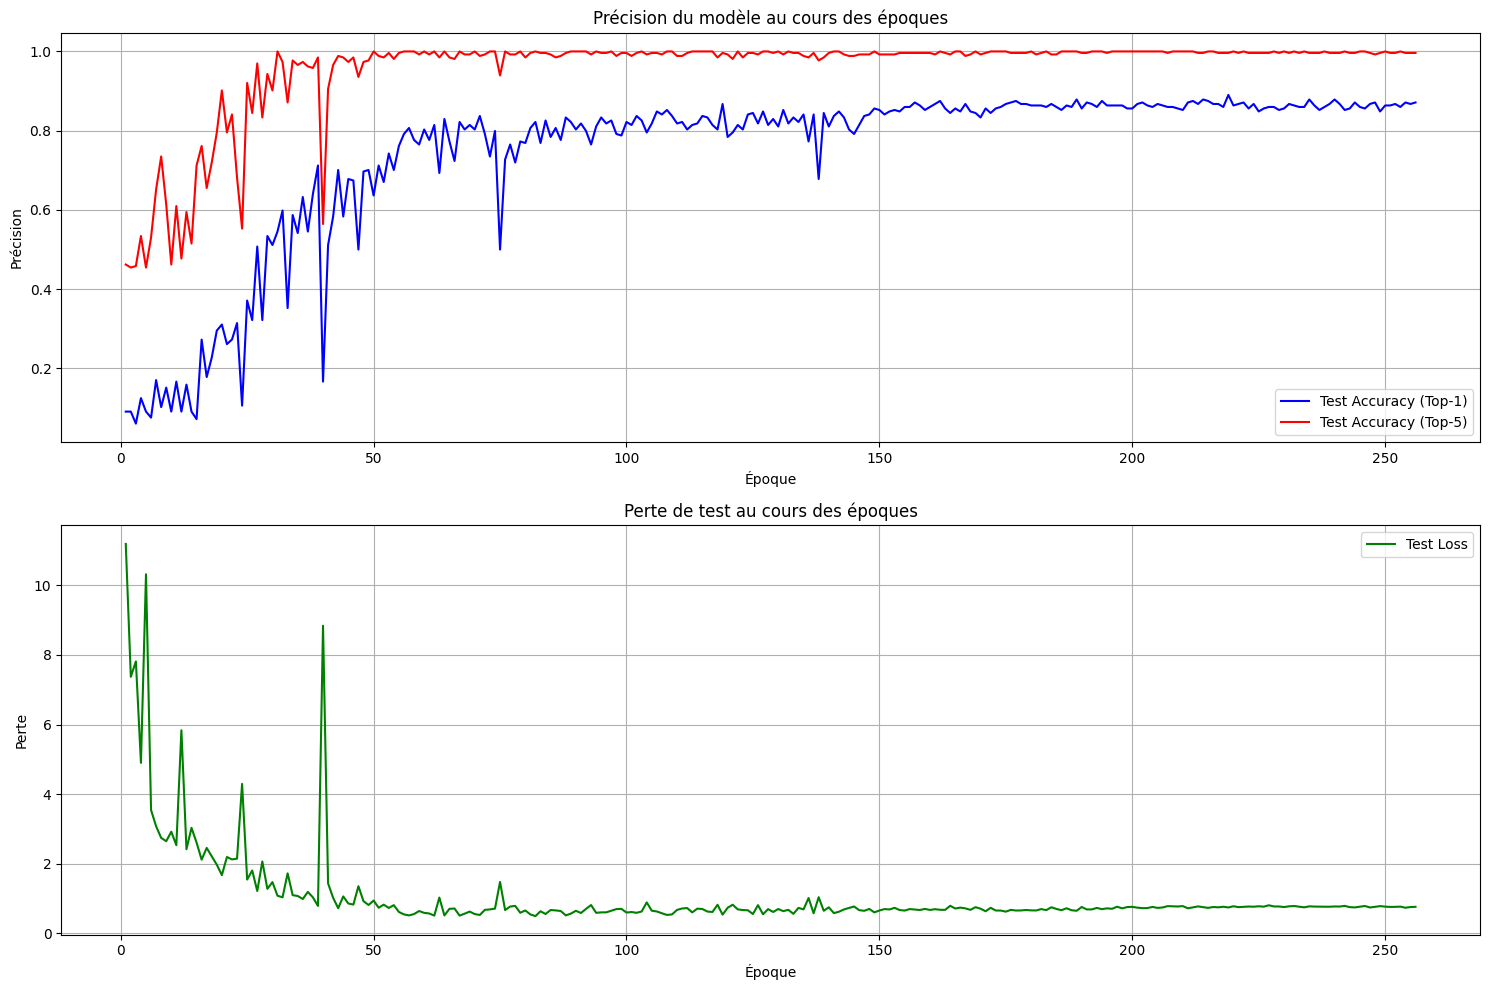

Meilleure précision: 0.8902 à l'époque 219.0


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix, top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

max_acc, best_epoch = plot_learning_curves(Record_path, Name_suffix, 5)
print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")

In [35]:
img, label = next(iter(test_data_loader))

In [36]:
net(img)

tensor([[12.8830,  4.2055, 13.6046, 15.4558, 27.6387, 22.0529, 40.2661, 24.8750,
         20.4456, 13.6894, 18.3791],
        [14.9146, 19.7554,  6.0727, 29.2955, 29.9265,  5.4151, 13.7218, 19.2194,
          7.7812, 12.8073, 18.8199],
        [15.2867, 19.1270,  7.1259, 28.5135, 33.6564,  4.7683, 18.3157, 19.2978,
          9.5919, 12.7149, 24.3464],
        [18.0080,  6.8156,  8.7516,  4.5479,  7.0307, 10.4072,  9.2068, 16.3459,
         25.1479, 14.0696, 12.8437],
        [13.2484, 15.9314, 29.3292,  5.0914,  3.2670, 15.6732, 14.2953, 12.5226,
          4.6393, 13.6653,  8.1541],
        [ 9.1074,  8.4554, 14.1608, 21.2657, 18.1366, 18.3710, 12.1014,  4.4407,
          9.1729, 27.0219, 32.6607],
        [11.5972,  0.1216, 18.5917, 28.5621,  8.4565, 44.2775, 28.6644, 12.6171,
         20.1878, 20.4330, 22.6893],
        [14.3116, 10.7645, 11.5330,  8.4191, 12.4411,  7.8763, 11.3829, 23.0951,
         15.8096, 15.4130,  7.4995],
        [11.1563,  4.8744, 14.8708, 13.1438, 11.4998, 19